# Edit graph state

## Build graph

In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

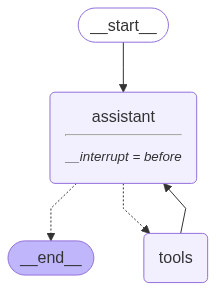

In [2]:
# Build agent

# Tool definitions

def multiply(a: int, b: int) -> int:
    """
        Function to multiply 2 given numbers
        The return value is an integer which is the product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """
        Function to add 2 given numbers
        The return value is an integer which is the sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
        Function to subtract 2 given numbers
        The return value is an integer which is the difference of a and b
    """
    return a - b

def divide(a: int, b: int) -> int:
    """
        Function to perform division on 2 given numbers
        The return value is an integer which is the quotient of a and b
    """
    return a / b

# Bind tools with Chat model
llm = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [multiply, add, subtract, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# Define LLM node
def assistant(state: MessagesState) -> MessagesState:
    systemMessage = [SystemMessage(content="You are a helpful assistant that can perform basic arithmetic operations.")]
    state["messages"] = llm_with_tools.invoke(systemMessage + state["messages"])
    return state

# Build Graph
memory = MemorySaver()
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("assistant", assistant)
graphBuilder.add_node("tools", ToolNode(tools))

graphBuilder.add_edge(START, "assistant")
graphBuilder.add_conditional_edges("assistant", tools_condition)
graphBuilder.add_edge("tools", "assistant")

graph = graphBuilder.compile(checkpointer = memory, interrupt_before = ["assistant"])
display(Image(graph.get_graph().draw_mermaid_png()))

## Interrupt and edit state

In [3]:
# Execute and observe interrupt
thread = {"configurable": {"thread_id": 1}}
input_message = [HumanMessage(content="What is the product of 445 and 238?")]

for event in graph.stream({"messages": input_message}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the product of 445 and 238?


In [4]:
# Edit/Update state
graph.update_state(thread,
                   {"messages": [HumanMessage(content="No find the product of 235 and 762")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b35d-7463-6f72-8001-75bd9aca0aa8'}}

In [5]:
# View state
new_state = graph.get_state(thread)
for m in new_state.values["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the product of 445 and 238?
================================ Human Message =================================

No find the product of 235 and 762


In [6]:
# Proceed with execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No find the product of 235 and 762
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JI35UaPYvSUvG6ycFR7gAvrR)
 Call ID: call_JI35UaPYvSUvG6ycFR7gAvrR
  Args:
    a: 235
    b: 762
================================= Tool Message =================================
Name: multiply

179070


In [7]:
# Get final response
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

179070
================================== Ai Message ==================================

The product of 235 and 762 is 179,070.


In [8]:
# Get full message sequence
state = graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the product of 445 and 238?
================================ Human Message =================================

No find the product of 235 and 762
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JI35UaPYvSUvG6ycFR7gAvrR)
 Call ID: call_JI35UaPYvSUvG6ycFR7gAvrR
  Args:
    a: 235
    b: 762
================================= Tool Message =================================
Name: multiply

179070
================================== Ai Message ==================================

The product of 235 and 762 is 179,070.


## Graph with separate node for human feedback to update state

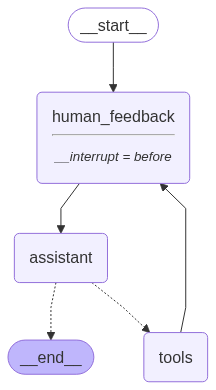

In [9]:
# Build graph

# Define feedback node
def human_feedback(state: MessagesState) -> MessagesState:
    pass

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("human_feedback", human_feedback)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "human_feedback")

feedback_graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
display(Image(feedback_graph.get_graph().draw_mermaid_png()))



In [10]:
# Test the setup
# Execute and observe interrupt
thread = {"configurable": {"thread_id": 2}}
input_message = [HumanMessage(content="What is the product of 445 and 238?")]

for event in feedback_graph.stream({"messages": input_message}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Ask for state update
feedback = input("How do you want to update the state?")

# Update the state
feedback_graph.update_state(thread, {"messages": HumanMessage(content=feedback)}, as_node="human_feedback")

# Continue execution
for event in feedback_graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the product of 445 and 238?
================================ Human Message =================================

No find the sum of 5 and 5
================================== Ai Message ==================================
Tool Calls:
  add (call_Nll8jtif2xzsPLn55FHHmc32)
 Call ID: call_Nll8jtif2xzsPLn55FHHmc32
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: add

10


In [11]:
# Generate final response
for event in feedback_graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The sum of 5 and 5 is 10.
